In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# investigate distriution
from collections import Counter

# re-sampling approach
from imblearn.over_sampling import SMOTE

# Split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model to use
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#hyperparameter tuning with random search and grid search
from sklearn.model_selection import PredefinedSplit # use for searching
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

Import the data set

In [3]:
df = pd.read_csv('Vehicle_insurance_encoded.csv')
df.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,...,VehicleCategory_Sedan,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow
0,0,1,21,0,5.0,0,12,300,1,4.0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,34,0,5.0,0,15,400,4,4.0,...,0,1,0,0,1,0,0,0,1,0
2,0,0,47,0,5.0,0,7,400,3,4.0,...,0,1,0,0,1,0,0,1,0,0
3,1,0,65,1,1.0,0,4,400,2,4.0,...,0,1,0,0,0,1,0,1,0,0
4,0,1,27,1,5.0,0,3,400,1,4.0,...,0,1,0,0,1,0,0,0,1,0


In [4]:
# input
X = df.drop(columns=['FraudFound_P'])

# target
y = df['FraudFound_P']

Preprocessing

1. train-val-test split

In [5]:
#Split the Data into Train-Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

2. Scaling using standard scaler

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Training set size:", X_train.shape)
print("Development set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (9252, 61)
Development set size: (3084, 61)
Testing set size: (3084, 61)


Strategies:

- SMOTE + ML models (RF, XGB): SMOTE-RF and SMOTE-XGB
- Cost-sensitive ML Models (RF, XGB): CS-RF and CS-XGB

### SMOTE + ML

1. SMOTE data

In [7]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

2. SMOTE data for hyperparameter searching

In [8]:
# Combine the training and validation data back into a single dataset for GridSearchCV
X_combined = np.vstack((X_smote, X_val))
y_combined = np.hstack((y_smote, y_val))

# Create the split index (training instances as -1, validation instances as 0)
split_index = [-1] * len(X_smote) + [0] * len(X_val)
pds = PredefinedSplit(test_fold=split_index)

3. SMOTE-RF

- Hyperparameter tuning for Random Forest

In [9]:
# Parameters of random forest
# Number of trees in random forest

random_grid_RF = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid_RF,
                               n_iter=100, cv=pds, verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

# Fit the model
rf_random.fit(X_combined, y_combined)

print("Best parameters found: ", rf_random.best_params_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  28.4s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time= 1.2min
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=  36.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time= 1.4min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=800; total time=  35.4s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=10

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
41 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
  

Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [ ]:
# Grid Search in smaller search space

In [10]:
# Best SMOTE-RF
smote_rf = rf_random.best_estimator_
test_score = smote_rf.score(X_test, y_test)
print("Test set score (SMOTE-RF):", test_score)

Test set score (SMOTE-RF): 0.9364461738002594


3. SMOTE-XGB

In [12]:
# Parameter grid for XGBoost
random_grid_XGB = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [int(x) for x in np.linspace(3, 10, num=8)],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.0, 0.1, 0.2, 0.5, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# RandomizedSearchCV setup
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=random_grid_XGB, 
                                n_iter=100, cv=pds, verbose=2, random_state=42, n_jobs=-1,scoring='f1_weighted')

xgb_random.fit(X_combined, y_combined)

print("Best parameters found: ", xgb_random.best_params_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=100, subsample=0.8; total time=   1.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=600, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=800, subsample=1.0; total time=   2.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   3.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   1.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   1.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   4.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   2.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=800, subsample=0.6; total time=   3.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   1.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=900, subsample=0.8; total time=   6.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.8; total time=   1.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=400, subsample=1.0; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   5.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   2.3s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   9.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   4.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   7.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=4, n_estimators=700, subsample=1.0; total time=   2.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=900, subsample=0.8; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   2.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=600, subsample=1.0; total time=   4.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   1.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   8.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   1.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=900, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   0.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   1.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   1.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   1.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   2.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=800, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=9, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   5.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   2.6s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   1.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   4.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   2.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   2.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   2.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=700, subsample=0.6; total time=   7.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.6; total time=   3.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   1.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:56:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=600, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=500, subsample=1.0; total time=   1.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   2.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=4, n_estimators=400, subsample=0.6; total time=   3.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   3.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   2.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   4.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   2.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   1.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   1.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=700, subsample=0.6; total time=   4.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.6; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.8; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   3.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   3.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   6.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=500, subsample=0.6; total time=   1.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, subsample=0.6; total time=   4.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=800, subsample=0.8; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   4.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   3.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=600, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   2.0s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   5.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=900, subsample

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


In [12]:
smote_xgb = xgb_random.best_estimator_
test_score_smote_xgb = smote_xgb.score(X_test, y_test)
print("Test set score (SMOTE-XGB):", test_score_smote_xgb)

Test set score (SMOTE-XGB): 0.9374189364461738


### Cost-Sensitive ML

Prepare the data

In [10]:
# Combine the training and validation data back into a single dataset for searching
X_combinedCS = np.vstack((X_train, X_val))
y_combinedCS = np.hstack((y_train, y_val))

# Create the split index (training instances as -1, validation instances as 0): predefined val
split_index = [-1] * len(X_train) + [0] * len(X_val)
pdsCS = PredefinedSplit(test_fold=split_index)

1. CSRF

In [14]:
csrf = RandomForestClassifier(class_weight='balanced')

csrf_random = RandomizedSearchCV(estimator=csrf, param_distributions=random_grid_RF,
                               n_iter=100, cv=pdsCS, verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

# Fit the model
csrf_random.fit(X_combinedCS, y_combinedCS)

print("Best parameters found (CS-RF): ", csrf_random.best_params_)


Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=   7.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1800; total time=  14.2s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=800; total time=   6.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   6.7s
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   4.6s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   0.0s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END bootstrap=False, max_depth=

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
41 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/base.py", line 637, in _validate_params
  

Best parameters found (CS-RF):  {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [15]:
# Best CS-RF
cs_rf = csrf_random.best_estimator_
test_score_csrf = cs_rf.score(X_test, y_test)
print("Test set score (CS-RF):", test_score_csrf)

Test set score (CS-RF): 0.930609597924773


CS-XGB

In [13]:
# Compute scale_pos_weight
scale_pos_weight = len(y_train[y == 0]) / len(y_train[y == 1])
# XGBoost classifier
csxgb = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight,eval_metric='logloss')

# RandomizedSearchCV setup
csxgb_random = RandomizedSearchCV(estimator=csxgb, param_distributions=random_grid_XGB, 
                                n_iter=100, cv=pdsCS, verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

csxgb_random.fit(X_combinedCS, y_combinedCS)

print("Best parameters found: ", csxgb_random.best_params_)


Fitting 1 folds for each of 100 candidates, totalling 100 fits


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=600, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=800, subsample=1.0; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=800, subsample=0.6; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=900, subsample=0.8; total time=   2.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   2.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=400, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   0.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=900, subsample=0.8; total time=   1.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=4, n_estimators=700, subsample=1.0; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=600, subsample=1.0; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=900, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=800, subsample=0.6; total time=   2.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=9, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=700, subsample=0.6; total time=   2.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=600, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=500, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=4, n_estimators=400, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   1.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=700, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.6; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   1.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   1.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   2.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=500, subsample=0.6; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:57:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=800, subsample=0.8; total time=   1.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=600, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=900, subsample

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [21:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'subsample': 1.0, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}


In [15]:
# Best CS-XGB
cs_xgb = csxgb_random.best_estimator_
test_score_csxgb = cs_xgb.score(X_test, y_test)
print("Test set score (CS-RF):", test_score_csxgb)

Test set score (CS-RF): 0.9286640726329443


### Evaluation

Model:

- smote_rf
- smote_xgb
- cs_rf
- cs_xgb

Evaluation:
- classification report
- confusion matrix
- ROC-AUC
- Area Under the Precision and Recall Curve (AUPRC)

In [18]:
# import
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

In [19]:
# function for evaluation

def performance_report(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    # Confusion Matrix with Percentages
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
    print("Normalized Confusion Matrix:")
    print(cm_normalized)

    # Plotting Normalized Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized * 100, annot=True, fmt=".2f", linewidths=.5, cmap="Blues", xticklabels=["Predicted No", "Predicted Yes"], yticklabels=["Actual No", "Actual Yes"])
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       1.00      0.01      0.01       197

    accuracy                           0.94      3084
   macro avg       0.97      0.50      0.49      3084
weighted avg       0.94      0.94      0.91      3084

Normalized Confusion Matrix:
[[1.         0.        ]
 [0.99492386 0.00507614]]


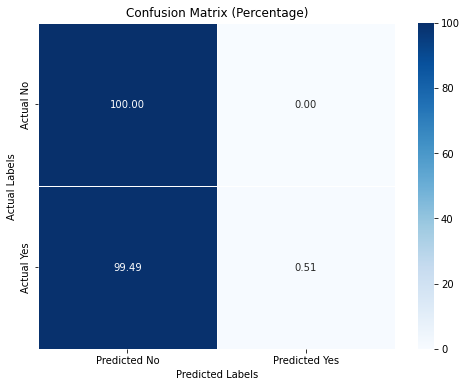

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2887
           1       0.58      0.08      0.13       197

    accuracy                           0.94      3084
   macro avg       0.76      0.54      0.55      3084
weighted avg       0.92      0.94      0.91      3084

Normalized Confusion Matrix:
[[0.99618982 0.00381018]
 [0.92385787 0.07614213]]


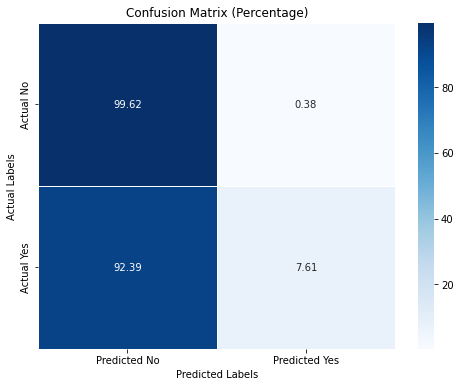

In [20]:
# smote_rf
performance_report(smote_rf)
# smote_xgb
performance_report(smote_xgb)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2887
           1       0.35      0.10      0.16       197

    accuracy                           0.93      3084
   macro avg       0.65      0.54      0.56      3084
weighted avg       0.90      0.93      0.91      3084

Normalized Confusion Matrix:
[[0.98718393 0.01281607]
 [0.89847716 0.10152284]]


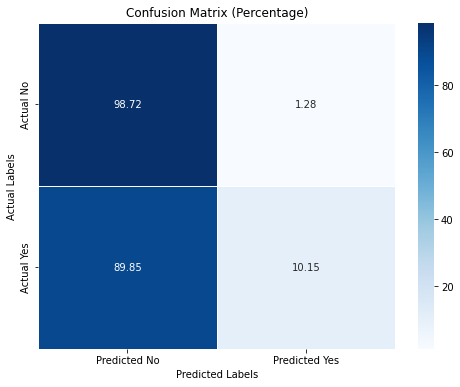

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2887
           1       0.37      0.16      0.23       197

    accuracy                           0.93      3084
   macro avg       0.66      0.57      0.59      3084
weighted avg       0.91      0.93      0.92      3084

Normalized Confusion Matrix:
[[0.98094908 0.01905092]
 [0.83756345 0.16243655]]


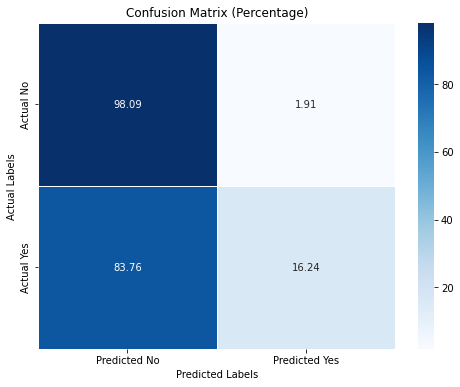

In [21]:
# cs_rf
performance_report(cs_rf)
# cs_xgb
performance_report(cs_xgb)

ROC

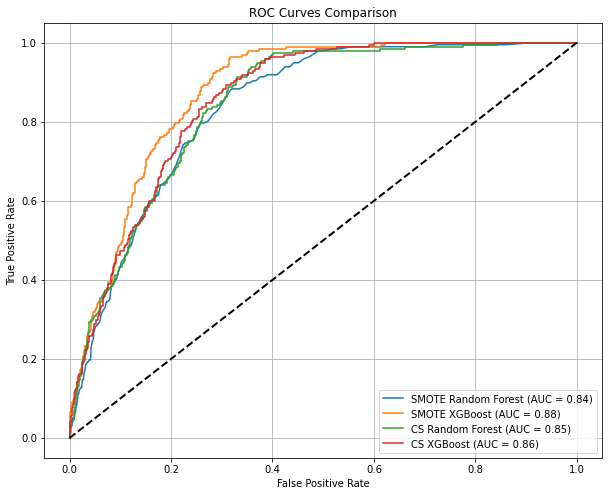

In [22]:
# calculate score
# smote_rf
smote_rf_prob = smote_rf.predict_proba(X_test)[:,1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, smote_rf_prob)
roc_auc1 = auc(fpr1, tpr1)
# smote_xgb
smote_xgb_prob = smote_xgb.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, smote_xgb_prob)
roc_auc2 = auc(fpr2, tpr2)

# cs_rf
cs_rf_prob = cs_rf.predict_proba(X_test)[:,1]
fpr3, tpr3, thresholds3 = roc_curve(y_test, cs_rf_prob)
roc_auc3 = auc(fpr3, tpr3)
# cs_xgb
cs_xgb_prob = cs_xgb.predict_proba(X_test)[:,1]
fpr4, tpr4, thresholds4 = roc_curve(y_test, cs_xgb_prob)
roc_auc4 = auc(fpr4, tpr4)

# ploting

# Setting up the plot
plt.figure(figsize=(10, 8))
plt.plot(fpr1, tpr1, label=f'SMOTE Random Forest (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'SMOTE XGBoost (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'CS Random Forest (AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, label=f'CS XGBoost (AUC = {roc_auc4:.2f})')

# Plotting the diagonal line which represents the no-skill classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')

# Grid for better readability
plt.grid(True)

# Show the plot
plt.show()

AUCPRC

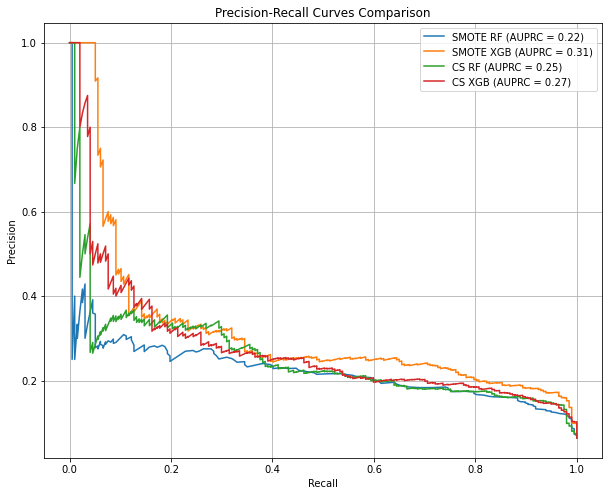

In [23]:
precision1, recall1, _ = precision_recall_curve(y_test, smote_rf_prob)
auprc1 = auc(recall1, precision1)

precision2, recall2, _ = precision_recall_curve(y_test, smote_xgb_prob)
auprc2 = auc(recall2, precision2)

precision3, recall3, _ = precision_recall_curve(y_test, cs_rf_prob)
auprc3 = auc(recall3, precision3)

precision4, recall4, _ = precision_recall_curve(y_test, cs_xgb_prob)
auprc4 = auc(recall4, precision4)

plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1, label=f'SMOTE RF (AUPRC = {auprc1:.2f})')
plt.plot(recall2, precision2, label=f'SMOTE XGB (AUPRC = {auprc2:.2f})')
plt.plot(recall3, precision3, label=f'CS RF (AUPRC = {auprc3:.2f})')
plt.plot(recall4, precision4, label=f'CS XGB (AUPRC = {auprc4:.2f})')

# Adding labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend(loc='best')

# Adding a grid
plt.grid(True)

# Show the plot
plt.show()


### Probability Calibration

In [24]:
from sklearn.calibration import calibration_curve

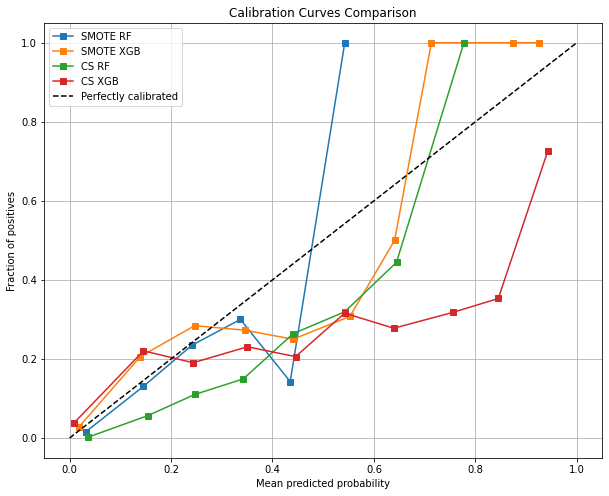

In [26]:
# calibration data for each model
fraction_of_positives1, mean_predicted_value1 = calibration_curve(y_test, smote_rf_prob, n_bins=10)
fraction_of_positives2, mean_predicted_value2 = calibration_curve(y_test, smote_xgb_prob, n_bins=10)
fraction_of_positives3, mean_predicted_value3 = calibration_curve(y_test, cs_rf_prob, n_bins=10)
fraction_of_positives4, mean_predicted_value4 = calibration_curve(y_test, cs_xgb_prob, n_bins=10)

plt.figure(figsize=(10, 8))
plt.plot(mean_predicted_value1, fraction_of_positives1, "s-", label='SMOTE RF')
plt.plot(mean_predicted_value2, fraction_of_positives2, "s-", label='SMOTE XGB')
plt.plot(mean_predicted_value3, fraction_of_positives3, "s-", label='CS RF')
plt.plot(mean_predicted_value4, fraction_of_positives4, "s-", label='CS XGB')

# Plot a perfectly calibrated model for comparison
plt.plot([0, 1], [0, 1], "k--", label='Perfectly calibrated')

# Adding labels, title, and legend
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves Comparison')
plt.legend(loc='best')

# Adding a grid for better readability
plt.grid(True)

# Show the plot
plt.show()

### Selected model without calibration

CS-XGB:

Best parameters found:  {'subsample': 1.0, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}